# Post-training dynamic range quantization

In [1]:
import tempfile
import os
import pathlib

import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow_model_optimization as tfmot

## load model

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


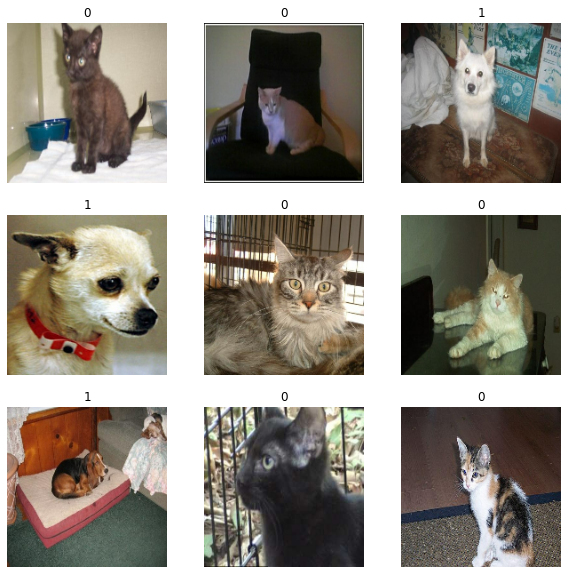

In [2]:
"""
## Generate a `Dataset`
"""

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

def scale(image, label):
    return tf.image.convert_image_dtype(image, tf.float32)/255, label

train_ds = train_ds.map(scale)
val_ds = val_ds.map(scale)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(((images[i].numpy())*255).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [3]:
model = tf.keras.models.load_model('../base')

Evaluate baseline test accuracy and save the model for later usage.

In [4]:
_, baseline_model_accuracy = model.evaluate(
    val_ds, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Baseline test accuracy: 0.9551665186882019
Saved baseline model to: C:\Users\rost_\AppData\Local\Temp\tmpklcf6s0o.h5


c:\tf_gpu_test\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Convert to a TensorFlow Lite model.

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\rost_\AppData\Local\Temp\tmpfr66m5kk\assets


c:\tf_gpu_test\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [6]:
tflite_models_dir = pathlib.Path("/tmp/tmp_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [7]:
tflite_model_file = tflite_models_dir/"tmp_model.tflite"
tflite_model_file.write_bytes(tflite_model)

11084464

In [8]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"tmp_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\rost_\AppData\Local\Temp\tmp6ecatsls\assets


INFO:tensorflow:Assets written to: C:\Users\rost_\AppData\Local\Temp\tmp6ecatsls\assets
c:\tf_gpu_test\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2997200

In [10]:
with open('../new_models/post_training_dynamic_range_quantization.tflite', 'wb') as f:
    f.write(tflite_quant_model)    